In [37]:
import numpy as np
import statistics as stat
import itertools
from copy import deepcopy
import copy
from scipy.stats  import multivariate_normal
import matplotlib 
# matplotlib.use('TkAgg')
%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
from IPython.core.debugger import set_trace
import random
import time
import math
import seaborn as sns; sns.set()
import pylab
from random import randrange
import sys 
import scipy
import plotly.graph_objects as go


import warnings
warnings.filterwarnings("ignore")

In [112]:
class grid_kem(object):
    def __init__(self, grid_size = (200, 200), distr ="Rand", n=2):
        '''
        Inputs:
            - Grid size: size of the grid.
            - Distribution: str.Showing type of initial distribution of the grid
                            Seg: Segregated
                            SM: Semi-mixed (greater granulity)
                            Mix: Completely mixed
                            Rand: Random grid
 
            - In case of SM distribution, n is an int value that represents
                the size of the neighborhoods. Default: 2.
                    
            
        '''
        #initiating
        self.grid_size = grid_size
        self.distr = distr
        self.n = n

        #populate 
        self.populate(grid_size, distr, n)
        
        #counting steps
        self.step = 0
    
    
    def populate(self, grid_size, distr, n):
        '''
        Populate the grid.
        Input: 
            - Grid Size (grid_size)
            - Distribution (distr)
            - Granularity size (n)
        
        We populate the grid depending on the type of geometry distribution selected.
        (Well mixed city (chessboard-like), Semi-mixed(chessboard-like but with greater granularity (n)), 
        Segregated (completely segregated grid))
        In this case we just have two possible income values 5 or 1, this allows us to simplify possible 
        outcomes of the model.
        
        Output:
            Income grid with selected attributes.
            We may add the "savings distributions right here.
        
        '''
        # Random grid case
        if self.distr == "Rand":
            self.income = np.ones(self.grid_size)
            for i in range(self.grid_size[0]):
                for j in range(self.grid_size[1]):
                    self.income[i][j] = np.random.uniform(0, 100) 


        # Segregated grid case
        elif self.distr == "Seg":
            self.income = np.ones(self.grid_size)*5
            self.income[:, :int(self.grid_size[1]/2)]= 1
        
        
        # Semi-mixed grid case, using n to consider the granularity
        elif self.distr == "SM":
            self.income = np.ones(self.grid_size)*5
            
            for i in range(self.n, 2*self.n):
                for j in range(self.n):
                    self.income[j::2*self.n, i::2*self.n] =1

            for i in range(self.n):
                for j in range(self.n, 2*self.n):
                    self.income[j::2*n, i::2*self.n] =1
                    
            
        #well mixed grid
        elif self.distr == "Mix" :
            self.income = np.ones(self.grid_size)*5
            for i in range(self.grid_size[0]):
                for j in range(self.grid_size[1]):
                    if (i+j)%2:
                        self.income[i][j] = 1
                        
                        
        self.lamb = np.ones(self.grid_size)
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                self.lamb[i][j] = np.random.power(0.3) 

        
    def gini(self, p):
        '''
        Gini coefficient (equation from wikipedia)
        
        '''
    
        y = sorted(p)
        n = len(p)

        numer = 2 * sum((i+1) * y[i] for i in range(n))
        denom = n * sum(y)

        return (numer / denom) - (n + 1) / n
    
    
    def percent(self, pct, items):
        '''
        The item that is pct percent through the sorted list of items.

        '''
        return items[min(len(items)-1, len(items) * pct // 100)]

        
    def display(self):
        '''
        Plot the state of the model.
        
        '''
        plt.figure()
        plt.imshow(self.income)
        plt.colorbar()
        plt.title('Step: ' + str(self.step))
        
        
    def hist(self, p, label='Dist', **kwargs):
        
        label = label + ': G=' + str(round(self.gini(p), 2))

        h = plt.hist(list(p), alpha = 0.4, bins = 30, label= label, **kwargs)

        plt.xlabel('Income')
        plt.ylabel('Count')
        plt.grid(True)

        plt.legend()
        
        
    def interaction(self, income): 
        '''
        Takes one actor randomly from the whole grid, 
        and a random neighbor actor.

        '''
        random_cell =random.sample(range(len(self.income)), 2)
        x = random_cell[0]
        y = random_cell[1]

        #having cut-off boundary conditions
        if x == 0:
            a =[0, 1]

        elif x == (self.grid_size[0]-1):
            a = [-1, 0]

        elif x !=0 and x !=(self.grid_size[0]-1):
            a=[-1, 0, 1]

        if y == 0:
            b = [0, 1]

        elif y == (self.grid_size[1]-1):
            b = [-1, 0]

        elif y !=0 and y != (self.grid_size[1]-1):
            b= [-1, 0, 1]

        combinations = itertools.product(a, b)

        neighbors = []
        for xi, yi in combinations:
            x_coordinate = (x + xi) % len(self.income[0])
            y_coordinate = (y + yi) % len(self.income[1])

            neighbors.append((x_coordinate, y_coordinate))

        neighbors.remove((x, y))
        choice = random.choice(neighbors)
        return (x, y), (choice[0], choice[1]) 
        
    def transaction(self, A, B):
        '''
        Type of Transaction. Need to add the saving distribution.
        
        '''
        eps = np.random.uniform()

    
        return self.lamb[A]*self.income[A] + eps*((1-self.lamb[A]) * self.income[A] + (1 - self.lamb[B])*self.income[B]), self.lamb[B]*self.income[B] + (1-eps)*((1 - self.lamb[A]) * self.income[A] + (1 - self.lamb[B])*self.income[B])
    
    
    def simulate(self, income, steps):
        '''
        Simulate takes a certain initial population, and makes them interact.

        Inputs:
            population. list. Initial income distribution
            steps. int. Time steps to execute the simulation
            transaction. function. function that describes the dynamic of the transaction.
            interaction. function. function that describes the dynamic of the interaction.

        Outputs:
            population after steps number of steps. 

        '''
        self.income = deepcopy(self.income)
        yield self.income

        for t in range(1, steps + 1):
            A, B = self.interaction(self.income)
            self.income[A], self.income[B] = self.transaction(A, B)

            yield self.income
    
    def run(self, income, k=500, **kwargs):
        '''
        Run the simulation for k* grid_size[0] steps, 
        return updated grid
        
        '''
        
        results = []
        sorted_results = []
        times = []
        
        for (t, pop) in enumerate(self.simulate(self.income, k*self.grid_size[0], **kwargs)):
            if t % (self.grid_size[0]/10) == 0:
                results.append(copy.copy(list(pop.flatten())))
                sorted_results.append(sorted(list(pop.flatten())))
                times.append(copy.copy(t))
                
        return results, sorted_results, times
    
    def show(self, income, k=500, percentiles=(1, 10, 50, 90, 99), **kwargs):
        '''
        Print stats, plot and histogram
        
        '''
        N = self.grid_size[0]*self.grid_size[1]
        
        start = list(self.income.flatten())
        
        results, sorted_results, times = self.run(self.income, k, **kwargs)
        
        #Statistics
        print('   t    Gini stdev' + (' {:3d}%' * len(percentiles)).format(*percentiles))
    
        fmt = '{:7,d} {:.2f} {:5.1f}' + ' {:4.0f}' * len(percentiles)
                
        for (t, pop) in zip(times, sorted_results):
            if t % (4* N) == 0:
                data = [self.percent(pct, pop) for pct in percentiles]
                print(fmt.format(t, self.gini(pop), statistics.stdev(pop), *data))
        
        #Plot

        plt.xlabel('Time')
        plt.ylabel('Wealth')
        plt.grid(True)

        for pct in percentiles:
            #TODO: this should average over all people in different percentiles, or make a separate thing to do that
            line = [self.percent(pct, pop) for pop in sorted_results]
            plt.plot(times, line)

        plt.show()
            
            
        #histogram
        pop = results[-1]
        R = (min(pop+start), max(pop+start))
        self.hist(start, 'Initial', range=R)
        self.hist(pop, 'Final', range=R)
        plt.show()
        plt.close()      


   t    Gini stdev   1%  10%  50%  90%  99%
      0 0.33  28.9    1   10   50   90   99


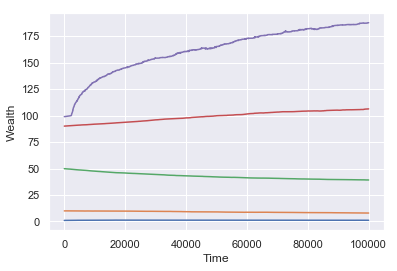

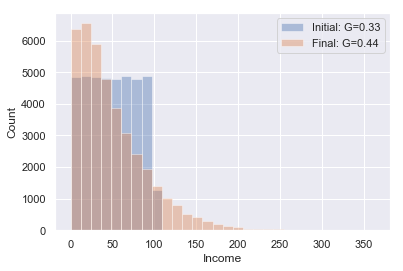

In [113]:
sim = grid_kem()
sim.show(sim.income)